# pdLSR: Pandas-aware least squares regression

In [1]:
from __future__ import print_function
import os
import inspect

import numpy as np
import pandas as pd

pd.set_option('display.float_format', lambda x: '%.2f' % x)
np.set_printoptions(precision=2)

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('talk')
sns.set_palette('dark')
sns.set_style('ticks')

%matplotlib inline

In [2]:
# Import pdLSR
try:
    # If pdLSR is in PYTHONPATH (or is installed), then use a direct import
    import pdLSR
    
except ImportError:
    # Attempt to demo pdLSR without installing by importing from directory
    pdLSR_path = '../../pdLSR'
    
    print("Module pdLSR was not found in PYTHONPATH. Looking for module in directory '{:s}'".format(pdLSR_path))
    
    if os.path.exists(pdLSR_path):
        import imp
        pdLSR = imp.load_package('pdLSR', pdLSR_path)
        print("Module pdLSR was found in the directory '{:s}' and imported.".format(pdLSR_path))
    else:
        raise ImportError("Module pdLSR could not be found in the directory '{:s}'.".format(pdLSR_path) + \
        "This demonstration will not run until the module is located.")

## Overview

`pdLSR` is a library for performing least squares minimization. It attempts to seamlessly incorporate this task in a Pandas-focused workflow. Input data are expected in dataframes, and multiple regressions can be performed using functionality similar to Pandas `groupby`. Results are returned as grouped dataframes and include best-fit parameters, statistics, residuals, and more. The results can be easily visualized using [`seaborn`](https://github.com/mwaskom/seaborn).

`pdLSR` currently utilizes [`lmfit`](https://github.com/lmfit/lmfit-py), a flexible and powerful library for least squares minimization, which in turn, makes use of `scipy.optimize.leastsq`. I began using `lmfit` because it is one of the few libraries that supports non-linear least squares regression, which is commonly used in the natural sciences. I also like the flexibility it offers for testing different modeling scenarios and the variety of assessment statistics it provides. However, I found myself writing many `for` loops to perform regressions on groups of data and aggregate the resulting output. Simplification of this task was my inspiration for writing `pdLSR`.

`pdLSR` is related to libraries such as [`statsmodels`](http://statsmodels.sourceforge.net) and [`scikit-learn`](http://scikit-learn.org/stable/) that provide linear regression functions that operate on dataframes. However, these libraries don't support grouping operations on dataframes. Supporting `statsmodels` and `scikit-learn` is being considered. (And pull requests adding this functionality would be welcome.)

Some additional 'niceties' associated with the input of parameters and equations have also been incorporated. `pdLSR` also utilizes multithreading for the calculation of confidence intervals, as this process is time consuming when there are more than a few groups.

### Input data

This `pdLSR` demonstration utilizes nuclear magnetic resonance (NMR) data acquired at two different magnetic field strengths (14.1 and 18.8 T) on the DNA-binding region of a transcription factor called GCN4. For the purpose of this demonstration, analyzing this data requires determining the rate of exponential decay as a function of time for every amino acid residue at each of two magnetic field strengths. 

There are 12 amino acids in the enclosed data set, so using amino acid residue (`resi`) and magnetic field (`field`) as the `groupby` columns results in 24 minimization operations.

In [3]:
data = pd.read_csv('GCN4_twofield.tsv', sep='\t')
! head GCN4_twofield.tsv

resi	field	time	intensity
51	14.1	0.004	1624.219428
51	14.1	0.008	1491.46728
51	14.1	0.024	1022.717456
51	14.1	0.064	448.038543
51	14.1	0.096	270.116745
51	14.1	0.144	148.671651
51	14.1	0.208	103.322608
52	14.1	0.004	1614.38584
52	14.1	0.008	1500.47205


### Dataframe input

`pdLSR` uses a dataframe for input as well as a column (or list of columns, called `groupbycols` here) for the `groupby` operation prior to fitting. A string input corresponding to the independent data (`xname`) and dependent data (`yname`) are required. Errors for weighting during fitting (`yerr`, not used here) can also be used.

In [4]:
groupby = ['resi', 'field']
xname = 'time'
yname = 'intensity'
yerr = None

### Minimization equation

The function format required by `pdLSR` is similar that described in the [`lmfit` documentation](http://lmfit.github.io/lmfit-py/fitting.html#writing-a-fitting-function). Generally speaking, all fit parameters must appear first and they must be contained in a single variable or dictionary that is then unpacked inside the function. The independent (x-) data is next and then the dependent (y-) data.

`pdLSR` contains a separate function that calculates the regression error, so the input function need only calculate the expected value based on input parameters.

Common equations are provided in the `function` module. Currently, an exponential decay and a linear function are provided.

This demo will be using the exponential decay function, whose parameters are:  

$I_{(t)} = I_{(0)} \space e^{(-R * t)}$  

where $I_{(0)}$ is the initial intensity, $I_{(t)}$ is the intensity at time $t$, and $R$ is the exponential decay  rate. 

Here is what the exponential decay function looks like:  

In [5]:
exponential_decay = pdLSR.functions.exponential_decay
print(inspect.getsource(exponential_decay))

def exponential_decay(par, xdata):
    """An exponential decay function for minimization.

    Parameters
    ----------
    par : list or dictionary
        Contains the intitial intensity ('inten')
        and decay rate ('rate'),
        order must be as stated.
    xdata : array
        An array of dependent data.

    Returns
    -------
    ydata : array
        An exponential decay calculated from the parameters
        and the xdata."""
    
    # Parse multiple input parameter
    # formats for intensity, rate    
    if hasattr(par,'valuesdict'):
        # lmfit parameter format
        var = par.valuesdict()
        inten = var['inten']
        rate = var['rate']
    elif hasattr(par,'keys'):
        # dict format
        inten = par['inten']
        rate = par['rate']
    else:
        # array/list/tuple format
        inten = par[0]
        rate = par[1]

    # Calculate the y-data from the parameters
    return inten * np.exp(-1*rate*xdata)



### Parameters

Parameters are usually input as a dictionary, although dataframe input will soon be an option. The list of parameters must be the same as the order in which they are unpacked by the minimization function. The keys for each parameter follows the format used by [`lmfit`](). 

Parameter starting values can be a single value or a list. If a single value is entered, it is used for each measurement. If a list or array is entered (see the intensity values below), it must be the same length as the number of groups.

In [6]:
params = [{'name':'inten', 
           'value':np.asarray(data.groupby(groupby)[yname].max()), 
           'vary':True},
          {'name':'rate', 
           'value':20.0, 
           'vary':True}]

### Other inputs

The only minimization method (`method`) currently supported is Levenberg-Marquardt ('leastsq'). Other methods will be added in the future. 

The confidence interval(s) (`sigma`) to be calculated can be entered as a single value or a list. The default is 95% (0.95). The number of threads (`threads`) to use for confidence interval calculation will be automatically calculated if not explicitly set.

In [7]:
minimizer_kwargs = {'params':params,
                    'method':'leastsq',
                    'sigma':0.95,
                    'threads':None}

## Regression and prediction

Performing the regression is quite simple--just call the class `pdNLS` with input parameters set and then use the `fit` method. A best-fit line can be calculated using the `predict` method, which will create a dataframe called `model` to store the results.

In [9]:
fit_data = pdLSR.pdLSR(data, exponential_decay, groupby, 
                       xname, yname,
                       minimizer='lmfit',
                       minimizer_kwargs=minimizer_kwargs)
fit_data.fit()
fit_data.predict()

## Results

`pdLSR` creates five output tables:

* **data** for the input data, calculated data, and residuals
* **results** that contains the best-fit parameters and estimation of their error
* **stats** for statistics related to the regression, such as chi-squared and AIC
* **model** that contains a best-fit line created by the `predict` method
* **covar** that contains the covariance matrices

Here is part of the **results** table for a single residue and magnetic field:

In [10]:
resi = 51
field = 14.1

fit_data.data.loc[(resi, field)]

time  intensity   ycalc  residuals
resi field                                    
51   14.10  0.00    1624.22 1585.18      39.04
     14.10  0.01    1491.47 1465.35      26.12
     14.10  0.02    1022.72 1070.03     -47.32
     14.10  0.06     448.04  487.57     -39.53
     14.10  0.10     270.12  259.99      10.13
     14.10  0.14     148.67  101.23      47.44
     14.10  0.21     103.32   28.78      74.54

The **results** table contains best-fit parameters, their standard errors, and confidence intervals.

In [11]:
fit_data.results.head(n=4)

inten                 rate              
              value stderr  ci0.95 value stderr ci0.95
resi field                                            
51   14.10  1714.80  37.87   58.41 19.65   1.02   1.74
     18.80 24122.68 689.03 1134.59 21.64   1.58   2.81
52   14.10  1778.90  17.87   32.10 23.35   0.49   0.96
     18.80 23889.26 232.87  538.02 29.96   0.79   1.69

The **stats** table contains statistics for each of the regressions:

* Number of observations (`nobs`)
* Number of fit parameters (`npar`)
* Degrees of freedom (`dof`)
* Chi-squared (`chisqr`)
* Reduced chi-squared (`redchi`)
* Akaike information criterion (`aic`)
* Bayesian information criterion (`bic`)

In [12]:
fit_data.stats.head(n=4)

nobs  npar  dof           chisqr           redchi    aic    bic
resi field                                                                 
51   14.10     7     2    5      46189329.09       9237865.82 116.27 116.16
     18.80     7     2    5 5181283778043.33 1036256755608.67 197.67 197.56
52   14.10     7     2    5       2013267.84        402653.57  94.34  94.23
     18.80     7     2    5  184908562051.39   36981712410.28 174.34 174.23

It is also easy to access a single covariance matrix for calculations.

In [13]:
fit_data.covar.loc[(resi, field)]

row  col   covar
resi field                  
51   14.10    0    0 1434.41
     14.10    0    1   25.19
     14.10    1    0   25.19
     14.10    1    1    1.04

In [14]:
fit_data.pivot_covar().loc[(resi, field)].values

array([[  1.43e+03,   2.52e+01],
       [  2.52e+01,   1.04e+00]])

## Visualization

The results are easy to visualize in facet plots with Seaborn. The facet plots will be easier to see if the intensities are normalized first.

In [15]:
fit_itensities = fit_data.results.loc[:,('inten','value')]

In [16]:
fit_data.data['intensity'] = fit_data.data.intensity.div(fit_itensities)
fit_data.model['ycalc'] = fit_data.model.ycalc.div(fit_itensities)

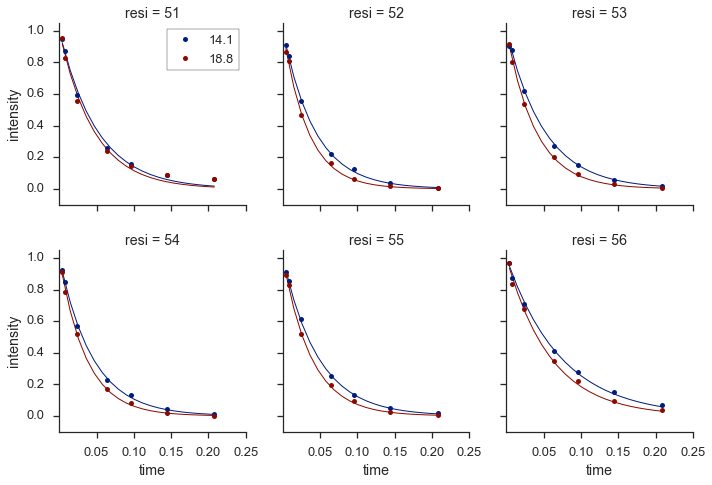

In [17]:
plot_data = pd.concat([fit_data.data, 
                       fit_data.model], axis=0).reset_index()

colors = sns.color_palette()

palette = {14.1:colors[0], 18.8:colors[2]}

grid = sns.FacetGrid(plot_data, col='resi', hue='field', palette=palette,
                     col_wrap=3, size=2.0, aspect=0.75, 
                     sharey=True, despine=True)


grid.map(plt.plot, 'xcalc', 'ycalc', marker='', ls='-', lw=1.0)
grid.map(plt.plot, 'time', 'intensity', marker='o', ms=5, ls='')

grid.set(xticks=np.linspace(0.05, 0.25, 5),
         ylim=(-0.1, 1.05))

ax = grid.axes[0]
legend = ax.get_legend_handles_labels()
ax.legend(legend[0][2:], legend[1][2:], loc=0, frameon=True)

f = plt.gcf()
f.set_size_inches(12,8)
f.subplots_adjust(wspace=0.2, hspace=0.25)

Just for fun, here's a bar graph of the decay rates determined from NLS.

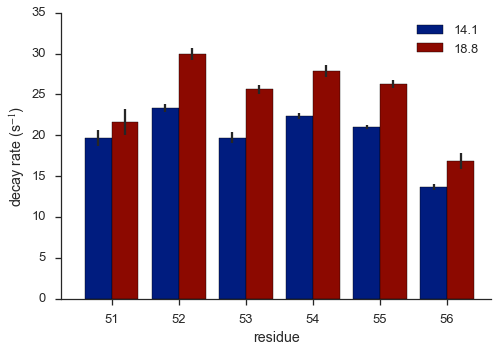

In [18]:
plot_data = (fit_data.results
             .sort_index(axis=1)
             .loc[:,('rate',['value','stderr'])]
             )
plot_data.columns = plot_data.columns.droplevel(0)
plot_data.reset_index(inplace=True)

fig = plt.figure()
fig.set_size_inches(7,5)
ax = plt.axes()

palette = [colors[0], colors[2]]

for pos, (field, dat) in enumerate(plot_data.groupby('field')):
    _ = dat.plot('resi', 'value', yerr='stderr',
                 kind='bar', label=field, color=palette[pos],
                 position=(-pos)+1, ax=ax, width=0.4)
    
ax.set_ylabel('decay rate (s$^{-1}$)')
ax.set_xlabel('residue')
ax.set_xlim(ax.get_xlim()[0]-0.5, ax.get_xlim()[1])
plt.xticks(rotation=0)

sns.despine()
plt.tight_layout()